# III - Data Analysis

In [1]:
import os
import urllib.request
import tarfile
import sys

global DOWNLOADS_DIR 
DOWNLOADS_DIR= '.'

def download_and_extract(url):
    # Obtain the filename
    name = url.rsplit('/', 1)[-1]
    filename = os.path.join(DOWNLOADS_DIR, name)
    # Download the file if not found
    if not os.path.isfile(filename):
        urllib.request.urlretrieve(url, filename)
    # Decompress (if needed) and copy the selected file to the DOWNLOADS_DIR
    sdir=filename.rsplit('ReferenceImages',1)[0]+"ReferenceImages"
    if not os.path.isdir(sdir):
        tar = tarfile.open(filename)
        tar.extractall(path=DOWNLOADS_DIR)
        tar.close()

In [2]:
m100_url='https://bulk.cv.nrao.edu/almadata/sciver/M100Band3_12m/M100_Band3_ReferenceImages_CASA3.3.tgz'
download_and_extract(m100_url)

In [3]:
!ls M100_Band3_ReferenceImages

M100-CO.mom0.fits    M100-CO_map.png      M100line.image.fits
M100-CO.mom1.fits    M100-CO_velfield.png
M100-CO_contmap.png  M100cont.image.fits


In [4]:
from astropy.io import fits
import logging
import warnings
warnings.filterwarnings('ignore')

# Load File
hdulist = fits.open("M100_Band3_ReferenceImages/M100line.image.fits")
m100_hdu = hdulist[0]

## ACALib

ACALib is a ChiVO library for advanced computing for astronomical data. The stable version can be installed using ``pip``, the development version can be found at [github](https://github.com/ChileanVirtualObservatory/acalib) and the documentation is at [ReadTheDocs](http://acalib.readthedocs.io/en/latest/)

### NDData and Table
ACALib uses Astropy's Tables and N-Dimensional Data classes for all operations. 
Then, our first step is to convert from a fits file to the NDData object.

In [5]:
import acalib as aca
cube=aca.HDU_to_NDData(m100_hdu)
(cube,a,b) = aca.standarize(cube)

INFO: 4D data detected: assuming RA-DEC-FREQ-STOKES (like CASA-generated ones), and dropping STOKES [acalib.io.fits]
INFO: overwriting Masked Objects's current mask with specified mask. [astropy.nddata.nddata]


### Noise Selector

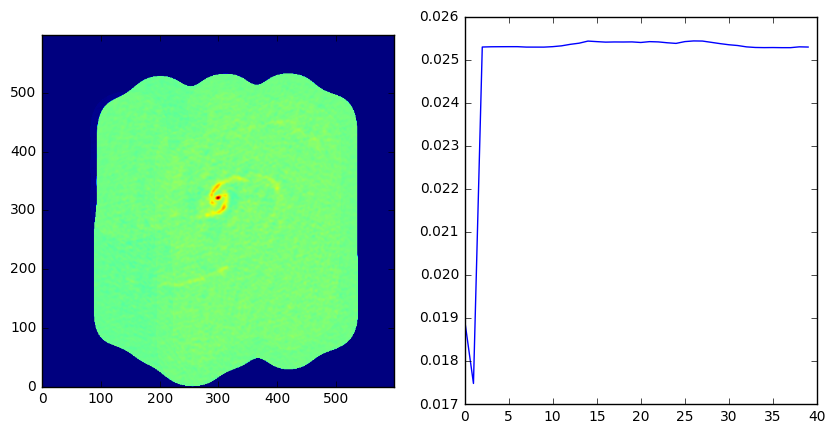

In [24]:
from ipywidgets import interact
import numpy as np
import matplotlib.pyplot as plt


ra_max   = cube.meta['NAXIS1']
dec_max  = cube.meta['NAXIS2']
spec_max = cube.meta['NAXIS3']

def cut_and_show(rlow=0,rhigh=ra_max,
                 dlow=0,dhigh=dec_max,
                 slow=0,shigh=spec_max):
    tmp=cube.data[slow:shigh,dlow:dhigh,rlow:rhigh]
    
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(np.nansum(tmp,axis=(0)),origin='lower')
    plt.subplot(1,2,2)
    plt.plot(np.nansum(tmp,axis=(1,2)))
    plt.show()

res=interact(cut_and_show,
             rlow=(0,ra_max), rhigh=(0,ra_max),
             dlow=(0,dec_max),dhigh=(0,dec_max),
             slow=(0,spec_max),shigh=(0,spec_max))

In [25]:
limits=res.widget.kwargs

In [ ]:
lower        = [limits['slow'],limits['dlow'],limits['rlow']]
upper       = [limits['shigh'],limits['dhigh'],limits['rhigh']]
noisecube = aca.cut(cube,lower=lower,upper=upper)

In [ ]:
noise_level=aca.noise_level(noisecube)
(noise_level.value*a+b)*noise_level.unit

### Thresholding

In [ ]:
dencube=aca.denoise(cube,threshold=1.1*noise_level)
aca.visualize(aca.moment0(dencube))

### Clumpfind

In [49]:
algo=aca.algorithms.ClumpFind()
algo.config['RMS']=aca.noise_level(cube).value
cf_res=algo.run(cube)

In [50]:
(caa,pix)=cf_res

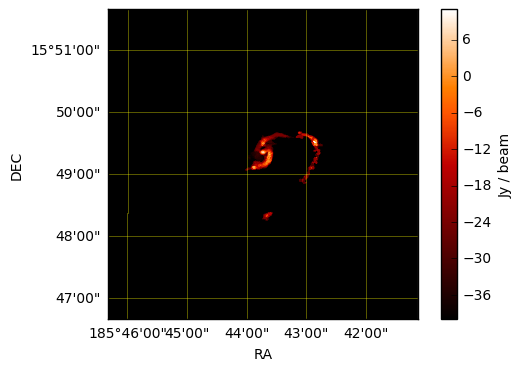

In [54]:
aca.visualize(aca.moment0(caa))

In [46]:
# Plot clumpfind

dict_keys([1, 66, 69, 70, 65, 8, 11, 76, 80, 81, 82, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 36, 37, 39, 43, 48, 56, 58, 60, 61, -1])

In [47]:
algo=aca.algorithms.Indexing()
in_res=algo.run(cube)

In [61]:
# Indexing

(40, 600, 600)


In [ ]:
#Stacking

In [ ]:
plt.figure()
syn2D=syn.sum(axis=(0))
vm=syn2D.max()
plt.subplot(121)
plt.imshow(syn2D,vmin=0,vmax=vm,origin='lower')
plt.subplot(122)
plt.imshow(res.sum(axis=(0)),vmin=0,vmax=vm,origin='lower')
plt.colorbar()
plt.show()

In [ ]:
from sompy.sompy import SOMFactory
newRep=rep['center'].data
sm = SOMFactory().build(newRep, normalization = 'var', initialization='pca')
sm.train(n_job=1, verbose=False, train_rough_len=30, train_finetune_len=30)

In [ ]:
sm.codebook.matrix

In [ ]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
def show_manifold(sm):
    cbook=sm.codebook.matrix
    fig=plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(cbook[:,0],cbook[:,1], cbook[:,2],c=cbook[:,0])#, c=c, marker=m)
    for cb,dm_elm in zip(cbook,sm._distance_matrix):
        conn=(dm_elm==1).nonzero()
        for idx in conn[0]:
            ot=cbook[idx]
            ax.plot([cb[0],ot[0]],[cb[1],ot[1]],[cb[2],ot[2]],color = 'Grey',alpha=0.5)
    plt.show()
show_manifold(sm)

## 4.- M100

In [ ]:
%matplotlib inline
# Extract File
download_extract_and_move(m100_url,m100_file)
# Load Fileinline
hdulist = fits.open(DOWNLOADS_DIR+'/'+m100_file)
m100_cube    = aca.HDU_to_NDData(hdulist[0])

In [ ]:
m100_cube.meta

In [ ]:
(ext1,ext2)=aca.extent(m100_cube)
ext1

In [ ]:
ext2

In [ ]:
cent=aca.center(m100_cube)
cent

In [ ]:
max_radius=(ext1[2]-cent[2])
max_radius.value

In [ ]:
%matplotlib inline
import aplpy
from astropy import units as u
from matplotlib.patches import Circle, Rectangle
(m100_cube,a,b) = aca.standarize(m100_cube)
m100_m0 = aca.moment0(m100_cube)


def select_radius(radius=max_radius.value):
    ax=plt.subplot(111,projection=m100_m0.wcs)
    ax.imshow(m100_m0.data,origin='lower',cmap='Greys')
    cc = Circle((cent[2].value,cent[1].value), radius=radius, edgecolor='green', facecolor='none',transform=ax.get_transform('fk5'))
    ax.add_patch(cc)

mycirc=interact(select_radius,radius=(0.0,max_radius.value,max_radius.value/1000))

In [ ]:
rad=mycirc.widget.kwargs['radius']
rad=(rad*u.deg).to('arcsec')
rad

In [ ]:
from astroquery import *
from astropy import coordinates
from astroquery.vizier import Vizier
catalog_list = Vizier.find_catalogs(keywords=['allWISE'])
for key,item in catalog_list.items():
    print(key+" : "+item.description)

In [ ]:
pos=coordinates.SkyCoord(cent[2],cent[1])
#print (fov*u.deg).to('arcsec')
#print cen*u.deg
tablist=Vizier.query_region(coordinates=pos,radius=rad)

In [ ]:
tablist

In [ ]:
atable=tablist['I/337/gaia']
atable

In [ ]:
fig = aplpy.FITSFigure(aca.NDData_to_HDU(m100_m0))
fig.show_grayscale()
fig.show_markers(atable['_RAJ2000'],atable['_DEJ2000'])

In [ ]:
%matplotlib inline
mside=(ext1[2] - ext2[2]).value
oside=(ext2[1] - ext1[1]).value



def select_noise(rside=mside/10.0,dside=oside/10.0,ra=cent[2].value,dec=cent[1].value,vini=ext1[0].value,vfin=ext2[0].value):
    ax=plt.subplot(121,projection=m100_m0.wcs)
    ax.imshow(m100_m0.data,origin='lower',cmap='Greys')
    cc = Rectangle((ra-rside,dec-dside),2*rside,2*dside,edgecolor='green', facecolor='none',transform=ax.get_transform('fk5'))
    ax.add_patch(cc)
    ax2=plt.subplot(122)
    ld=np.rint(m100_cube.wcs.wcs_world2pix([[ra-rside,dec-dside,vini]],0))
    lu=np.rint(m100_cube.wcs.wcs_world2pix([[ra+rside,dec+dside,vfin]],0))
    lower=np.array([ld,lu]).min(axis=0)[0]
    upper=np.array([ld,lu]).max(axis=0)[0]
    newcube=aca.cut(m100_cube,lower=lower[::-1],upper=upper[::-1])
    show_spectra(newcube)
    plt.show()


myrect=interact(select_noise,
                rside=(0.0,mside,mside/1000.0),
                dside=(0.0,oside,oside/1000.0),
                ra=(ext2[2].value,ext1[2].value,mside/1000.0),
                dec=(ext1[1].value,ext2[1].value,oside/1000.0),
                vini=(ext1[0].value,ext2[0].value),
                vfin=(ext1[0].value,ext2[0].value))

In [ ]:
print(oside)


In [ ]:
twhydra_cube    = aca.HDU_to_NDData(hdulist[0])